In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

def process_data(message_file_path):
    
    df_message = pd.read_csv(message_file_path)
    df_message["time_Bin"] = df_message["time"].astype(int)
    
    return df_message

In [3]:

def aggregate_order_counts(df_message, order_type1, order_type2, direction=None):
   
    df_filtered = df_message[df_message["type"].isin([order_type1, order_type2])]
    if direction is not None:
        df_filtered = df_filtered[df_filtered["dir"] == direction]

    #counts per second
    order_counts = df_filtered.pivot_table(index="time_Bin", columns="type", aggfunc="size", fill_value=0)

    if order_type1 in order_counts.columns and order_type2 in order_counts.columns:
        empirical_correlation = order_counts[order_type1].corr(order_counts[order_type2])
        lambda_1 = order_counts[order_type1].mean()
        lambda_2 = order_counts[order_type2].mean()
    else:
        empirical_correlation = None
        lambda_1, lambda_2 = None, None
    
    return order_counts, empirical_correlation, lambda_1, lambda_2


# Guassian Copular based correlation process

In [4]:
def simulate_orders(empirical_correlation, lambda_1, lambda_2, size=23400):
    
    
    empirical_correlation = np.clip(empirical_correlation, -0.99, 0.99)  # Ensure valid range
    
    mean = [0, 0]  # Standard normal mean
    cov_matrix = [[1, empirical_correlation], [empirical_correlation, 1]]  # Valid correlation matrix


    Z = np.random.multivariate_normal(mean, cov_matrix, size)
 
    # Transform to uniform distribution
    # This is the key idea behind copulas. The transformation preserves the dependency 
    # structure (the correlation) from the normal
    # distribution while changing the marginal distributions to uniform.
    
    # we are converting them into uniform variables
    U1 = stats.norm.cdf(Z[:, 0])
    U2 = stats.norm.cdf(Z[:, 1])

    
    #Converting Uniform Variables to Poisson-Distributed Variables
    X1 = stats.poisson.ppf(U1, lambda_1).astype(int)
    X2 = stats.poisson.ppf(U2, lambda_2).astype(int)

    # Compute simulated correlation
    simulated_corr = np.corrcoef(X1, X2)[0, 1]

    # Create DataFrame for simulated data
    df_simulated = pd.DataFrame({"Type 1": X1, "Type 2": X2})

    return df_simulated, simulated_corr




# Type 1 data And simulated cancellation data 
# Comparing Simulated data with the original data

In [5]:

def visualize_data(df_simulated, order_counts, order_type1, order_type2, empirical_correlation, simulated_corr):
    
    plt.figure(figsize=(18, 14))


    # Bar Chart of Order Counts Over Time (First 100 Intervals)
    plt.subplot(2, 2, 1)
    plt.bar(range(100), df_simulated["Type 1"][:100], color='blue', alpha=0.7, label="Type 1")
    plt.bar(range(100), df_simulated["Type 2"][:100], color='red', alpha=0.7, label="Type 2")
    plt.title("Bar Chart: Type 1 vs Type 2 (First 100 Intervals)")
    plt.xlabel("Time Interval")
    plt.ylabel("Order Count")
    plt.legend()

    # Full-Time Order Flow Comparison (Original vs Simulated)
    plt.subplot(2, 2, 2)
    plt.bar(df_simulated.index, df_simulated["Type 1"], color='blue', alpha=0.7, label="Type 1")
    plt.bar(df_simulated.index, df_simulated["Type 2"], color='red', alpha=0.7, label="Type 2")
    plt.title("Full-Time Type 1 vs Type 2")
    plt.xlabel("Time Interval")
    plt.ylabel("Order Count")
    plt.legend()

    #  Moving Average to Smooth Trends
    window_size = 100
    df_simulated["Moving Avg Type 1"] = df_simulated["Type 1"].rolling(window=window_size).mean()
    df_simulated["Moving Avg Type 2"] = df_simulated["Type 2"].rolling(window=window_size).mean()
    plt.subplot(2, 2, 3)
    plt.plot(df_simulated.index, df_simulated["Moving Avg Type 1"], label="Moving Avg Type 1", color='blue')
    plt.plot(df_simulated.index, df_simulated["Moving Avg Type 2"], label="Moving Avg Type 2", color='red')
    plt.title(f"Moving Average for Order Counts (Window Size = {window_size})")
    plt.xlabel("Time")
    plt.ylabel("Smoothed Order Count")
    plt.legend()

    #  Histogram of Simulated Poisson Counts
    plt.figure(figsize=(14, 8))
    sns.histplot(df_simulated["Type 1"], kde=True, color='blue', label='Type 1')
    sns.histplot(df_simulated["Type 2"], kde=True, color='red', label='Type 2', alpha=0.6)
    plt.title("Histogram of Simulated Poisson Counts")
    plt.xlabel("Count")
    plt.ylabel("Frequency")
    plt.legend()

    plt.tight_layout()
    plt.show()

    #  Original vs Simulated over time
    plt.figure(figsize=(14, 8))
    if order_type1 in order_counts.columns and order_type2 in order_counts.columns:
        plt.plot(order_counts.index, order_counts[order_type1], label="Original Type 1", color='blue')
        plt.plot(order_counts.index, order_counts[order_type2], label="Original Type 2", color='red', alpha=0.7)
    plt.plot(df_simulated.index, df_simulated["Type 1"], linestyle='dashed', color='blue', label="Type 1")
    plt.plot(df_simulated.index, df_simulated["Type 2"], linestyle='dashed', color='red', alpha=0.7, label="Type 2")
    plt.legend()
    plt.title("Original vs Simulated Order ")
    plt.xlabel("Time")
    plt.ylabel("Order Count")
    plt.show()

    #  Joint Distribution of Simulated vs Original Data 
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(x=df_simulated["Type 1"], y=df_simulated["Type 2"], bins=30, cmap='coolwarm', cbar=True)
    plt.xlabel("Type 1")
    plt.ylabel("Type 2")
    plt.title("Joint Distribution: Simulated Type 1 & Type 2")

    plt.subplot(1, 2, 2)
    if order_type1 in order_counts.columns and order_type2 in order_counts.columns:
        sns.histplot(x=order_counts[order_type1], y=order_counts[order_type2], bins=30, cmap='coolwarm', cbar=True)
    plt.xlabel("Original Type 1")
    plt.ylabel("Original Type 2")
    plt.title("Joint Distribution: Original Type 1 & Type 2")

    plt.tight_layout()
    plt.show()


    

# load file

In [6]:
message_file_path = "AAPL_2012-06-21_34200000_57600000_message_1.csv"  


df_message = process_data(message_file_path)
df_message

,time,type,id,size,price,dir,time_Bin
0,34200.004241,1,16113575,18,5853300,1,34200
1,34200.025552,1,16120456,18,5859100,-1,34200
2,34200.201743,3,16120456,18,5859100,-1,34200
3,34200.201781,3,16120480,18,5859200,-1,34200
4,34200.205573,1,16167159,18,5853600,1,34200
...,...,...,...,...,...,...,...
118492,57599.444020,4,287147169,103,5776000,1,57599
118493,57599.444020,4,287147170,11,5776000,1,57599
118494,57599.444020,1,287150868,48,5776100,-1,57599
118495,57599.913118,4,287150868,48,5776100,-1,57599


In [7]:
#  Type:
# 				1: Submission of a new limit order
# 				2: Cancellation (Partial deletion 
# 				   of a limit order)
# 				3: Deletion (Total deletion of a limit order)
# 				4: Execution of a visible limit order			   	 
# 				5: Execution of a hidden limit order
# 				7: Trading halt indicator 				   
# 				   (Detailed information below)


# Direction:
# 				-1: Sell limit order
# 				1: Buy limit order

Empirical Correlation: 0.7899684829255911
Simulated Correlation: 0.7562306368519397
Lambda1 (Type 1): 3.6603899572649574, Lambda2 (Type 2): 1.898838141025641


C:\Users\krish\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


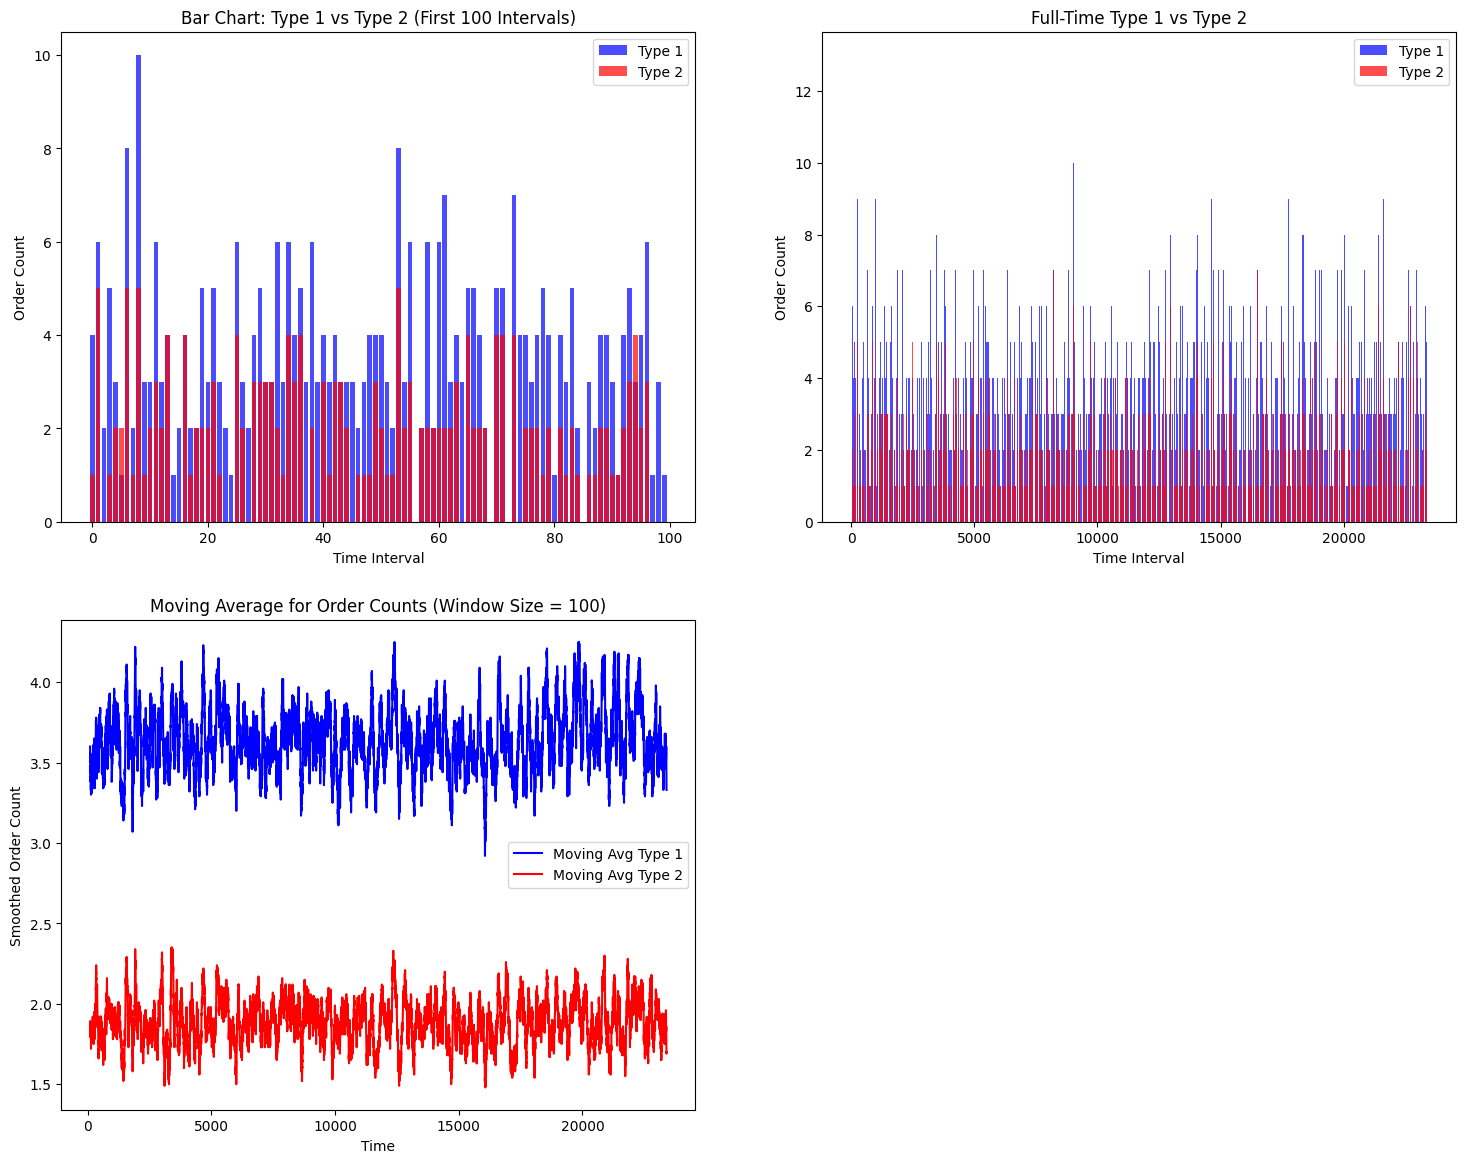

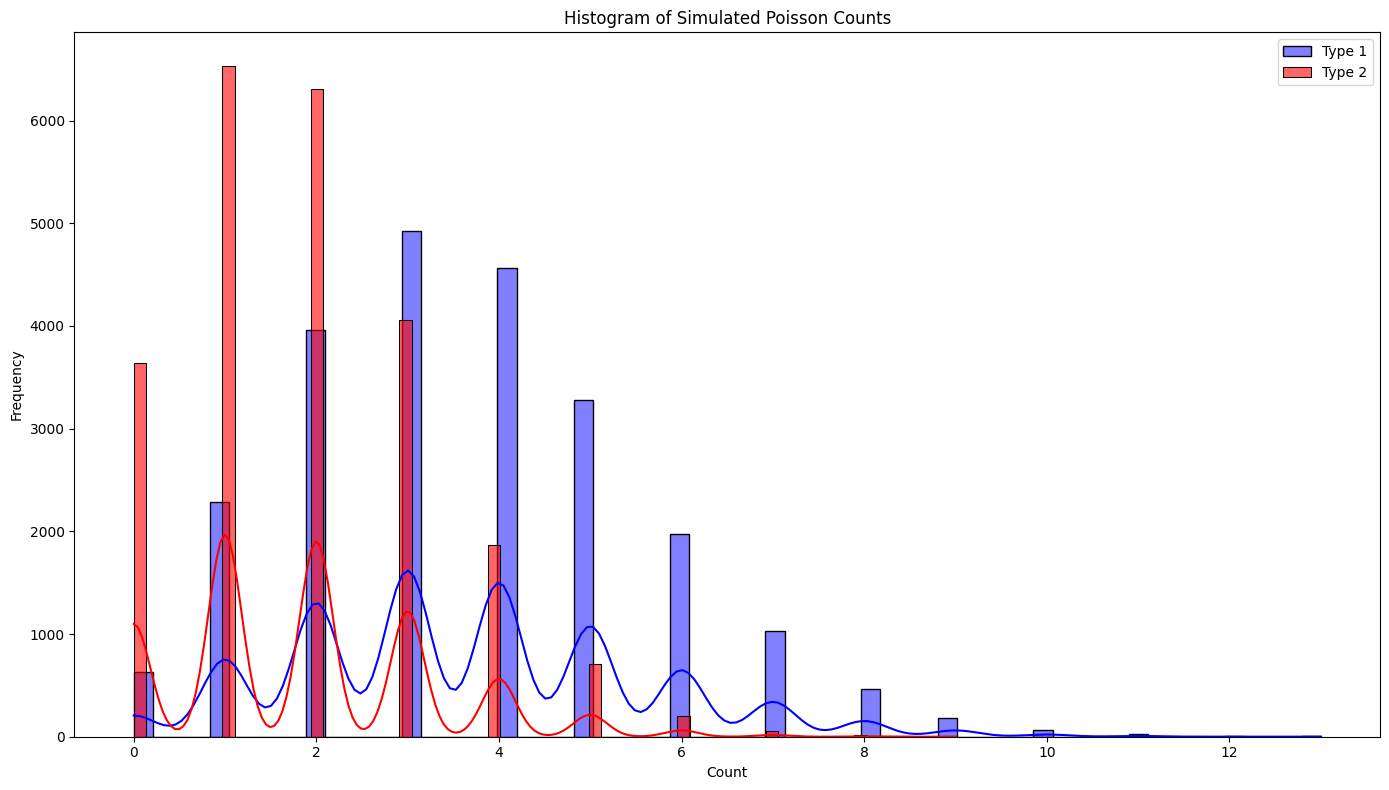

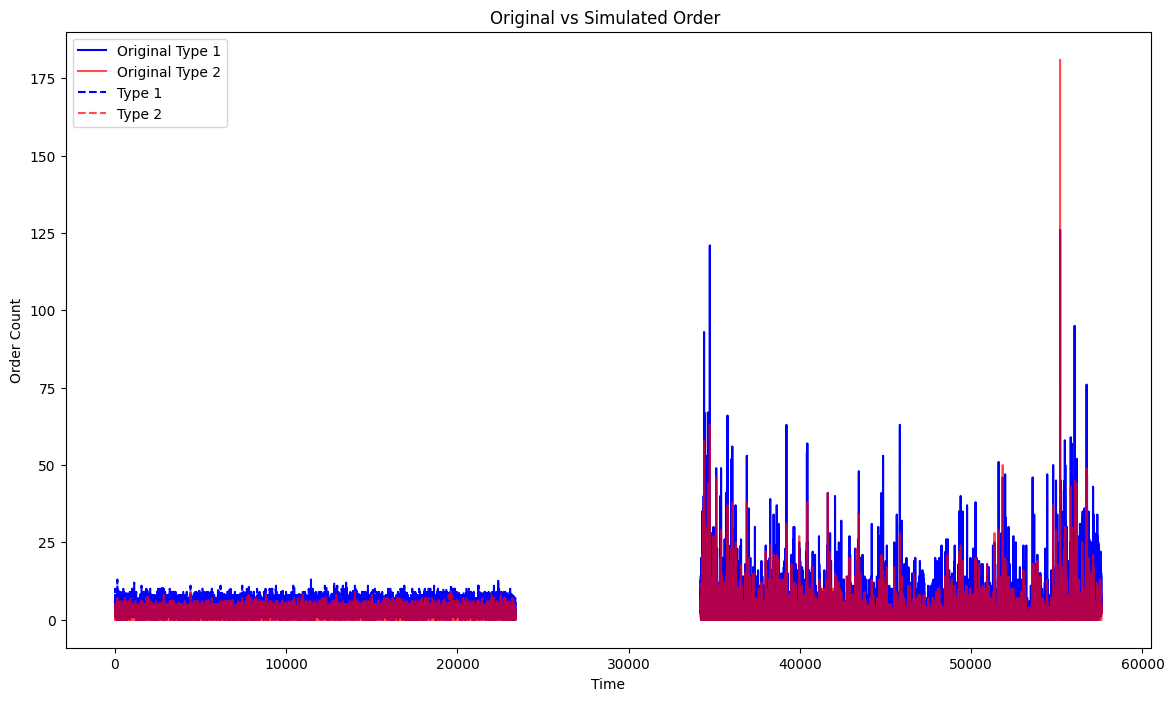

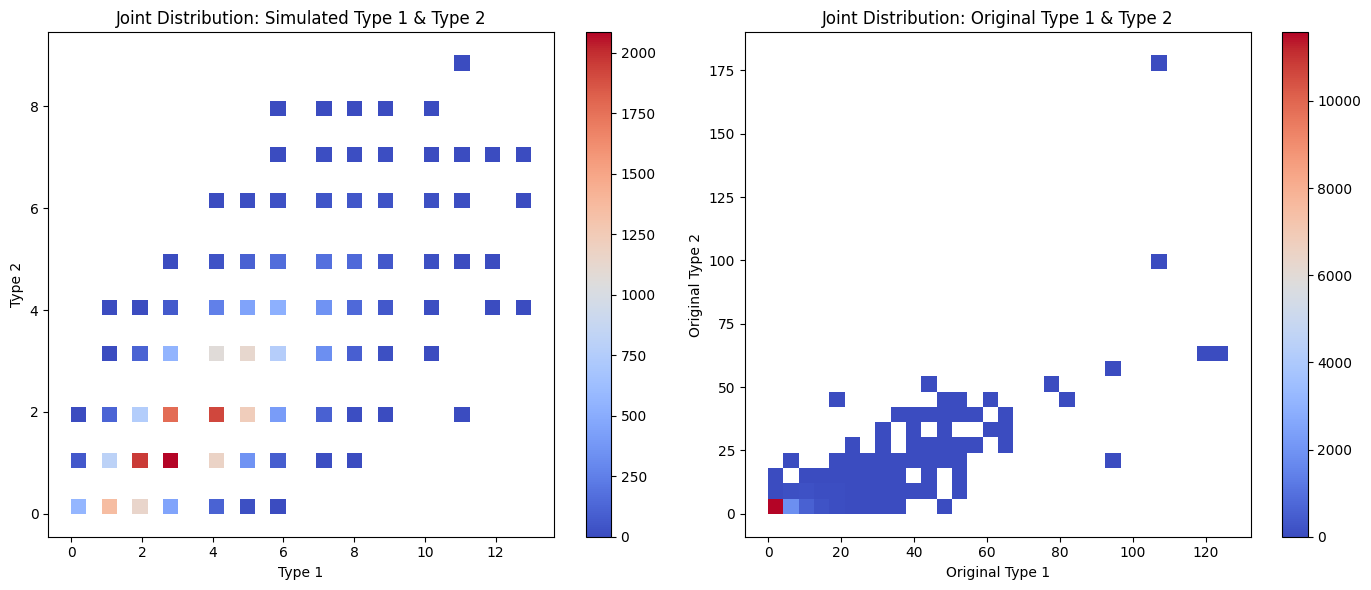

In [8]:


order_type1, order_type2 = 1, 3  # Can be any two from {1, 2, 3, 4, 5}
direction = None  # Can be 1 (Bid), -1 (Ask), or None for both

# Aggregate order counts
order_counts, empirical_correlation, lambda_1, lambda_2 = aggregate_order_counts(df_message, order_type1, order_type2, direction)

# Simulate data
df_simulated, simulated_corr = simulate_orders(empirical_correlation, lambda_1, lambda_2)

# Display values
print(f"Empirical Correlation: {empirical_correlation}")
print(f"Simulated Correlation: {simulated_corr}")
print(f"Lambda1 (Type 1): {lambda_1}, Lambda2 (Type 2): {lambda_2}")

# Visualize results
visualize_data(df_simulated, order_counts, order_type1, order_type2, empirical_correlation, simulated_corr)



## Limit arrival and execution of limit orders

Empirical Correlation: 0.5854699327758938
Simulated Correlation: 0.5642813568688176
Lambda1 (Type 1): 3.93496518555739, Lambda2 (Type 2): 1.698226975809346


C:\Users\krish\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


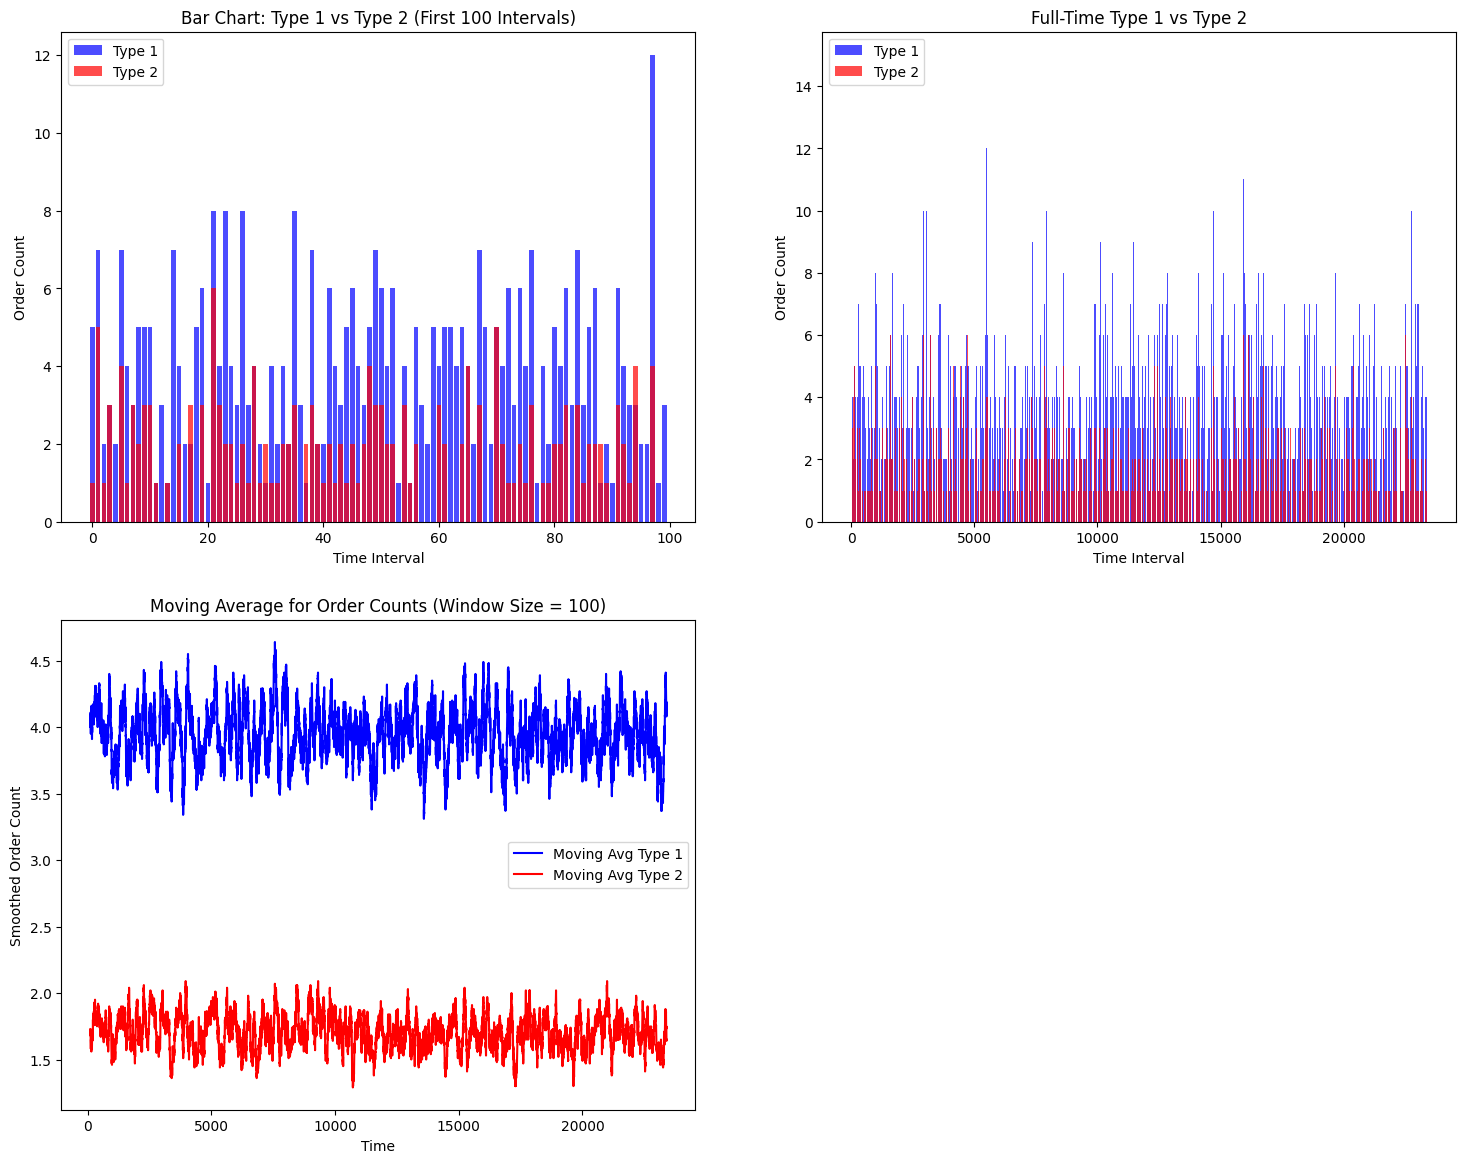

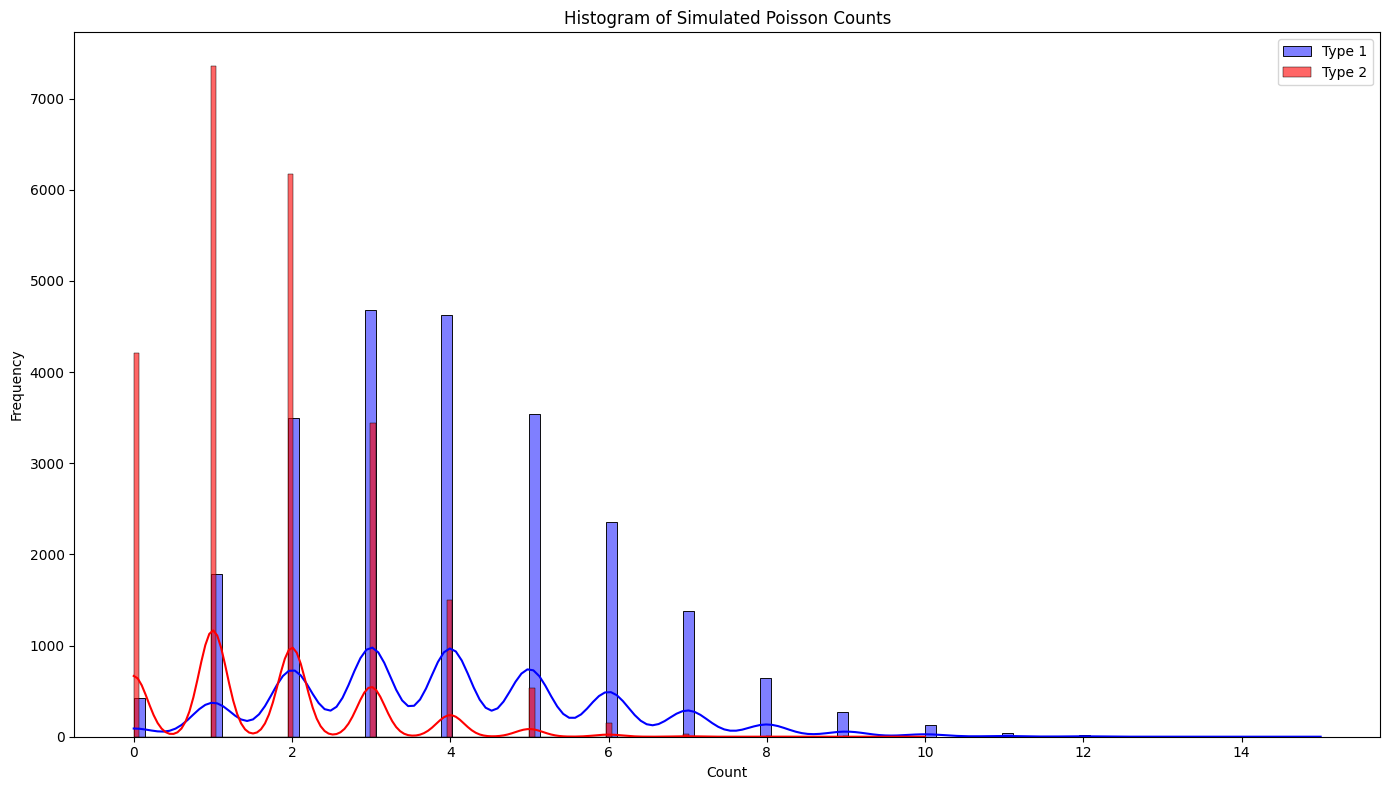

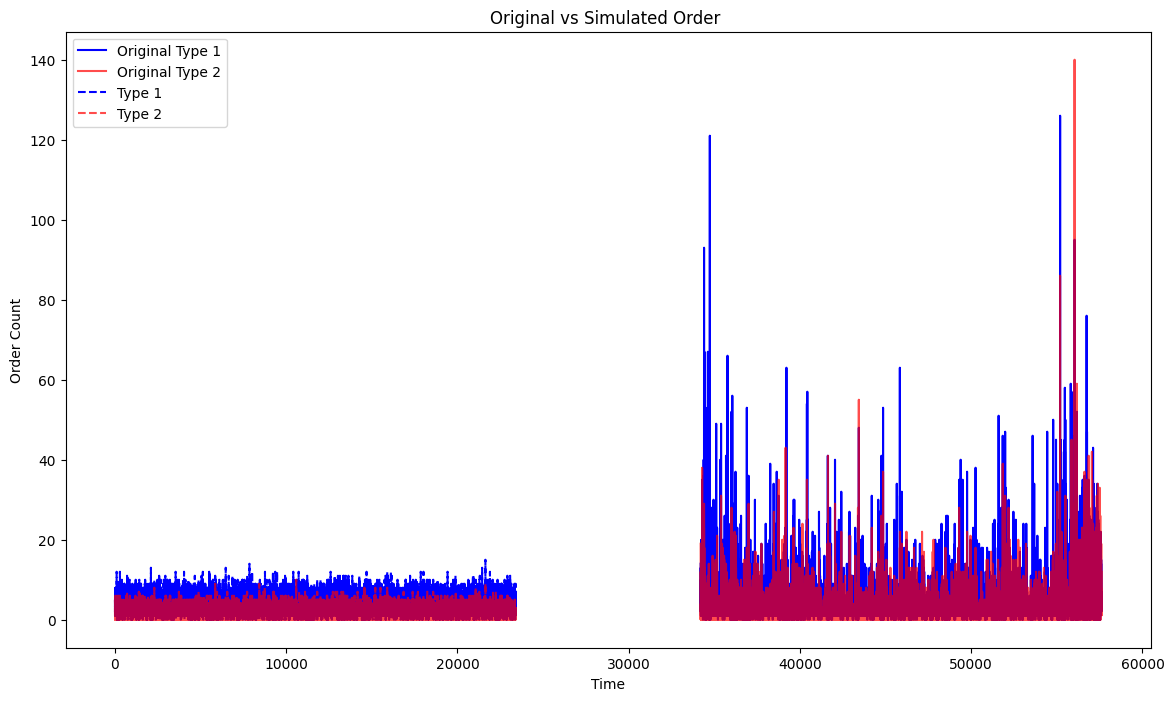

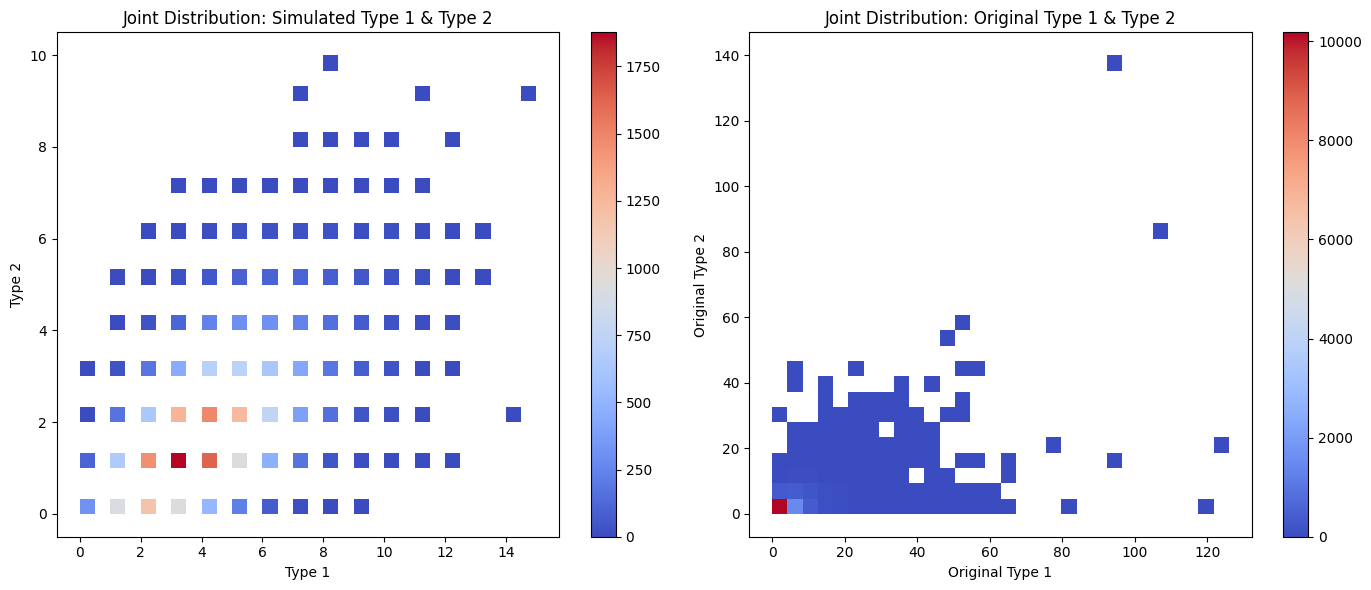

In [9]:


order_type1, order_type2 = 1, 4  # Can be any two from {1, 2, 3, 4, 5}
direction = None  # Can be 1 (Bid), -1 (Ask), or None for both

# Aggregate order counts
order_counts, empirical_correlation, lambda_1, lambda_2 = aggregate_order_counts(df_message, order_type1, order_type2, direction)

# Simulate data
df_simulated, simulated_corr = simulate_orders(empirical_correlation, lambda_1, lambda_2)

# Display values
print(f"Empirical Correlation: {empirical_correlation}")
print(f"Simulated Correlation: {simulated_corr}")
print(f"Lambda1 (Type 1): {lambda_1}, Lambda2 (Type 2): {lambda_2}")

# Visualize results
visualize_data(df_simulated, order_counts, order_type1, order_type2, empirical_correlation, simulated_corr)


## Limit deletion orders and limit execution orders

Empirical Correlation: 0.3687639675962997
Simulated Correlation: 0.34853177807917207
Lambda1 (Type 1): 2.5014954257565094, Lambda2 (Type 2): 2.0811048557353975


C:\Users\krish\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


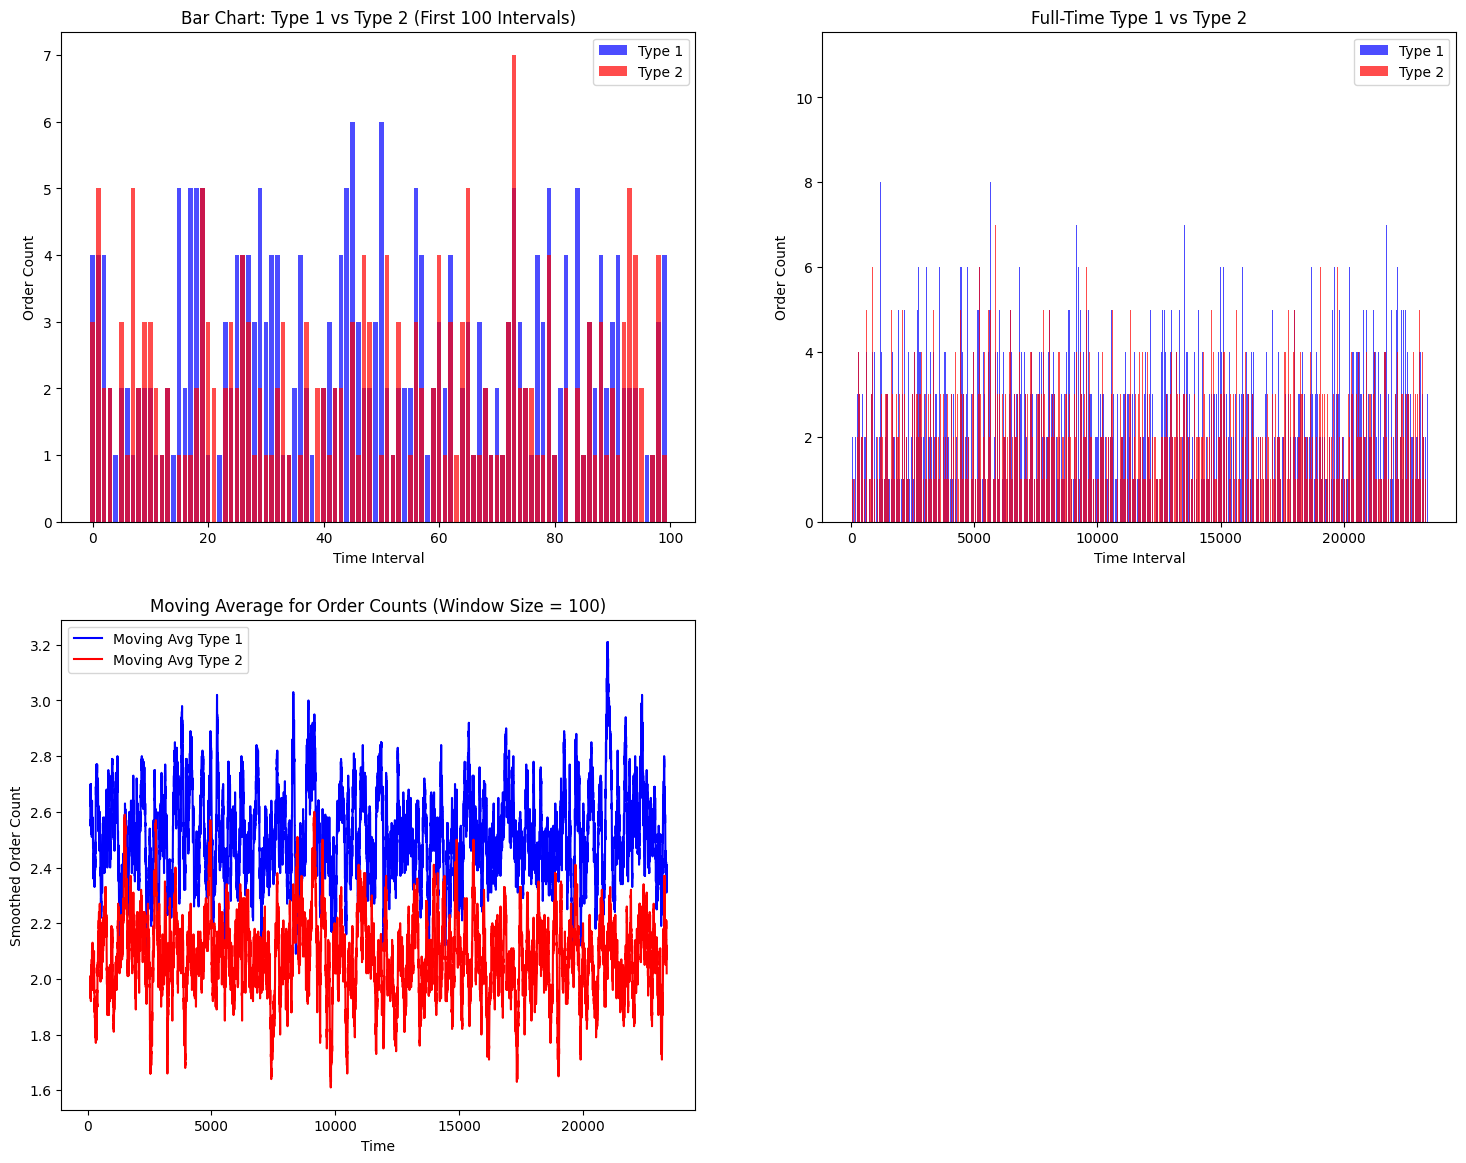

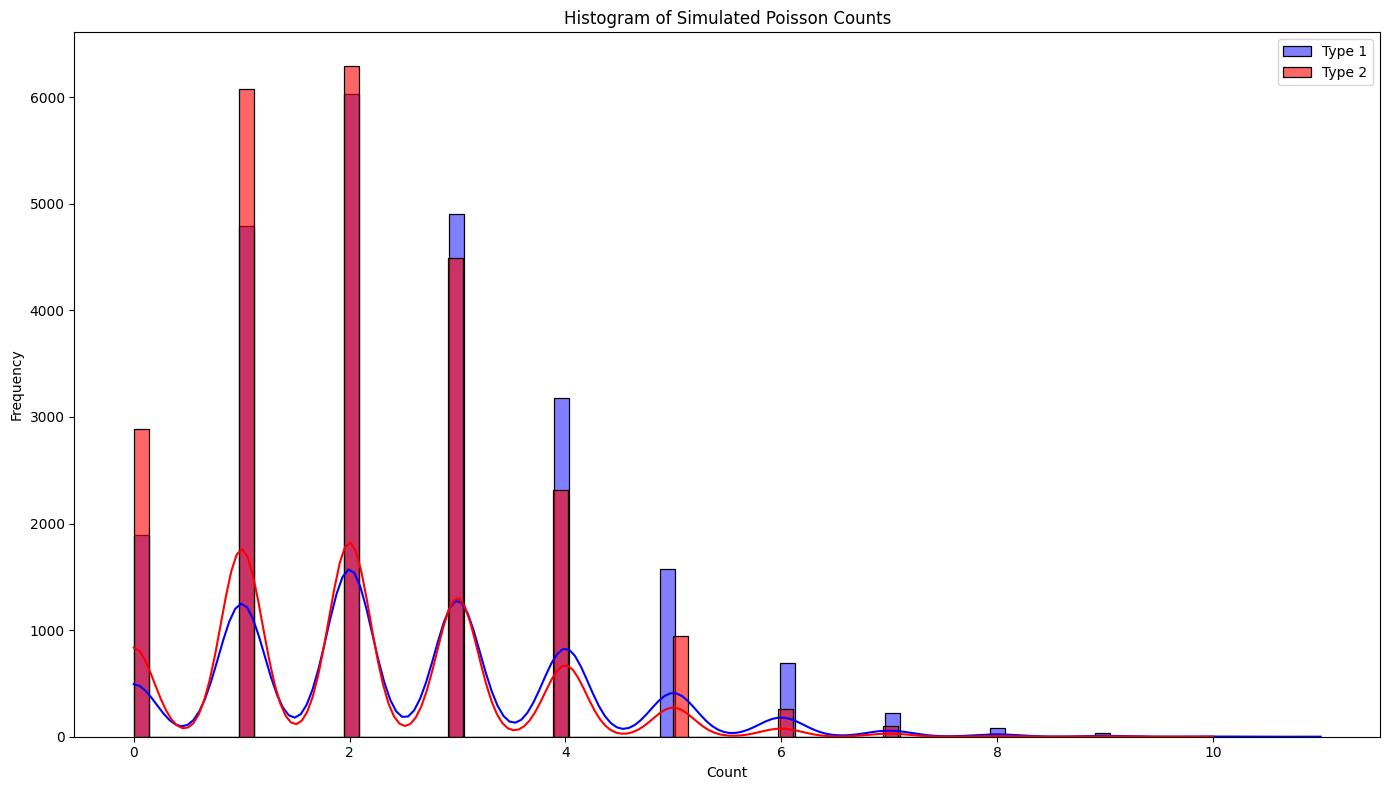

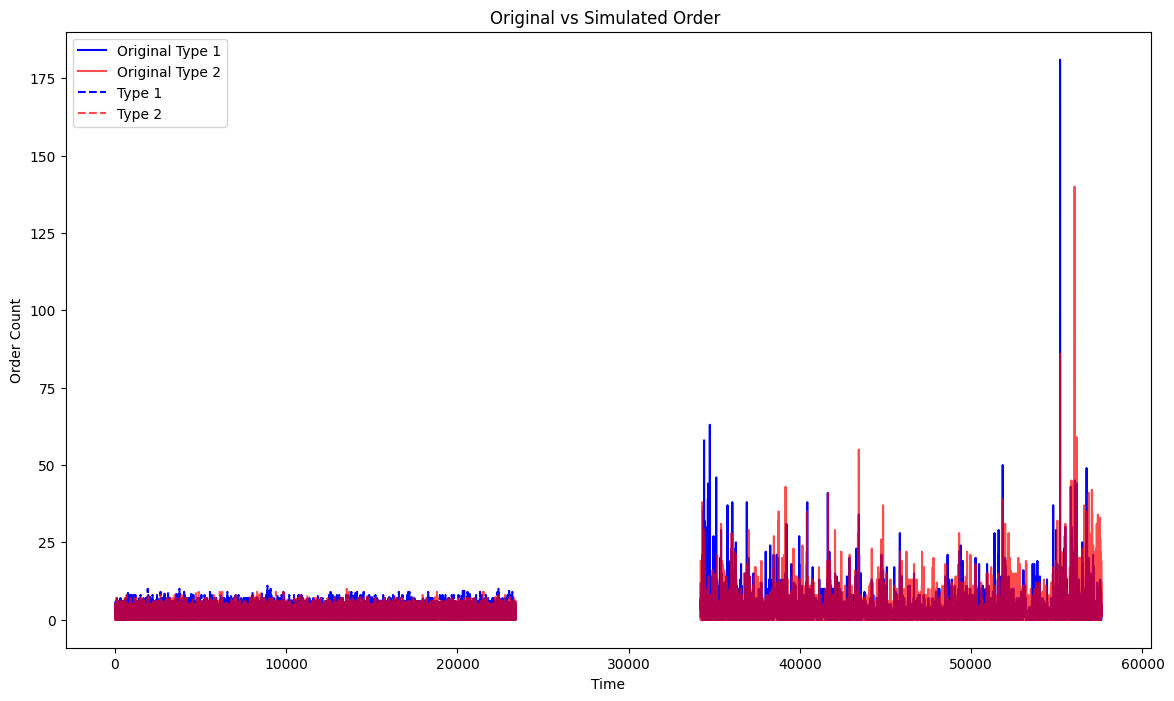

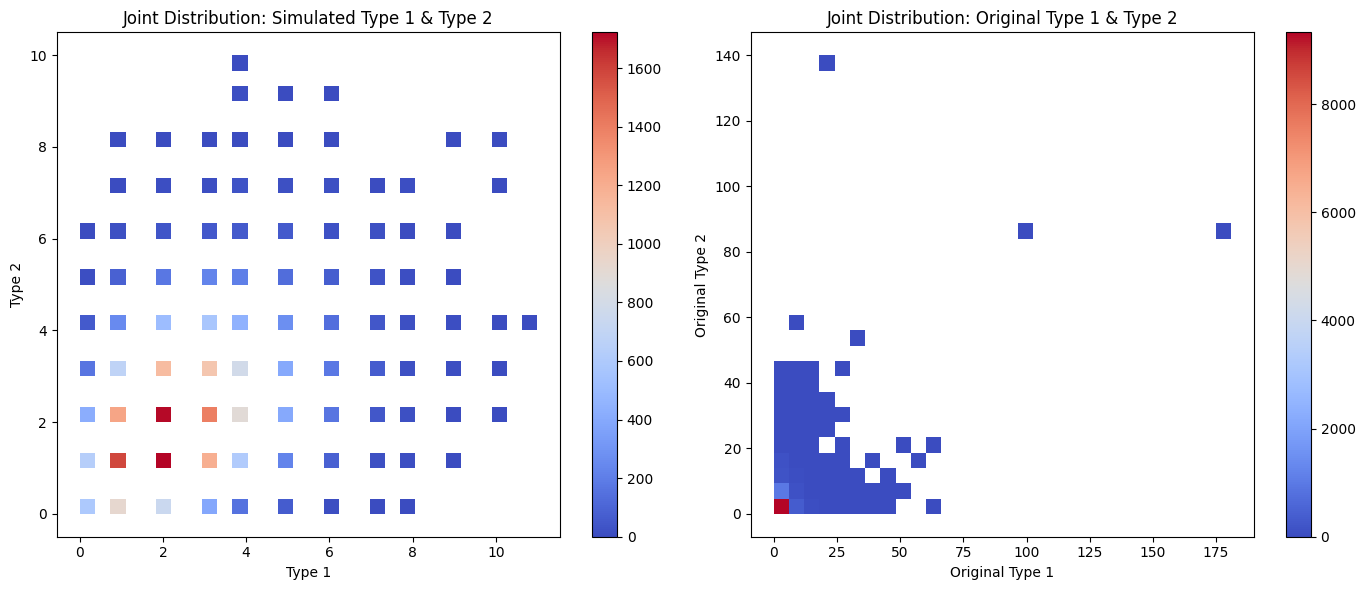

In [10]:


order_type1, order_type2 = 3,4  # Can be any two from {1, 2, 3, 4, 5}
direction = None  # Can be 1 (Bid), -1 (Ask), or None for both

# Aggregate order counts
order_counts, empirical_correlation, lambda_1, lambda_2 = aggregate_order_counts(df_message, order_type1, order_type2, direction)

# Simulate data
df_simulated, simulated_corr = simulate_orders(empirical_correlation, lambda_1, lambda_2)

# Display values
print(f"Empirical Correlation: {empirical_correlation}")
print(f"Simulated Correlation: {simulated_corr}")
print(f"Lambda1 (Type 1): {lambda_1}, Lambda2 (Type 2): {lambda_2}")

# Visualize results
visualize_data(df_simulated, order_counts, order_type1, order_type2, empirical_correlation, simulated_corr)


## Limit arrival and deletion orders (only bid)

Empirical Correlation: 0.7414032743300899
Simulated Correlation: 0.6941697770298109
Lambda1 (Type 1): 2.399712368168744, Lambda2 (Type 2): 1.3004793863854267


C:\Users\krish\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


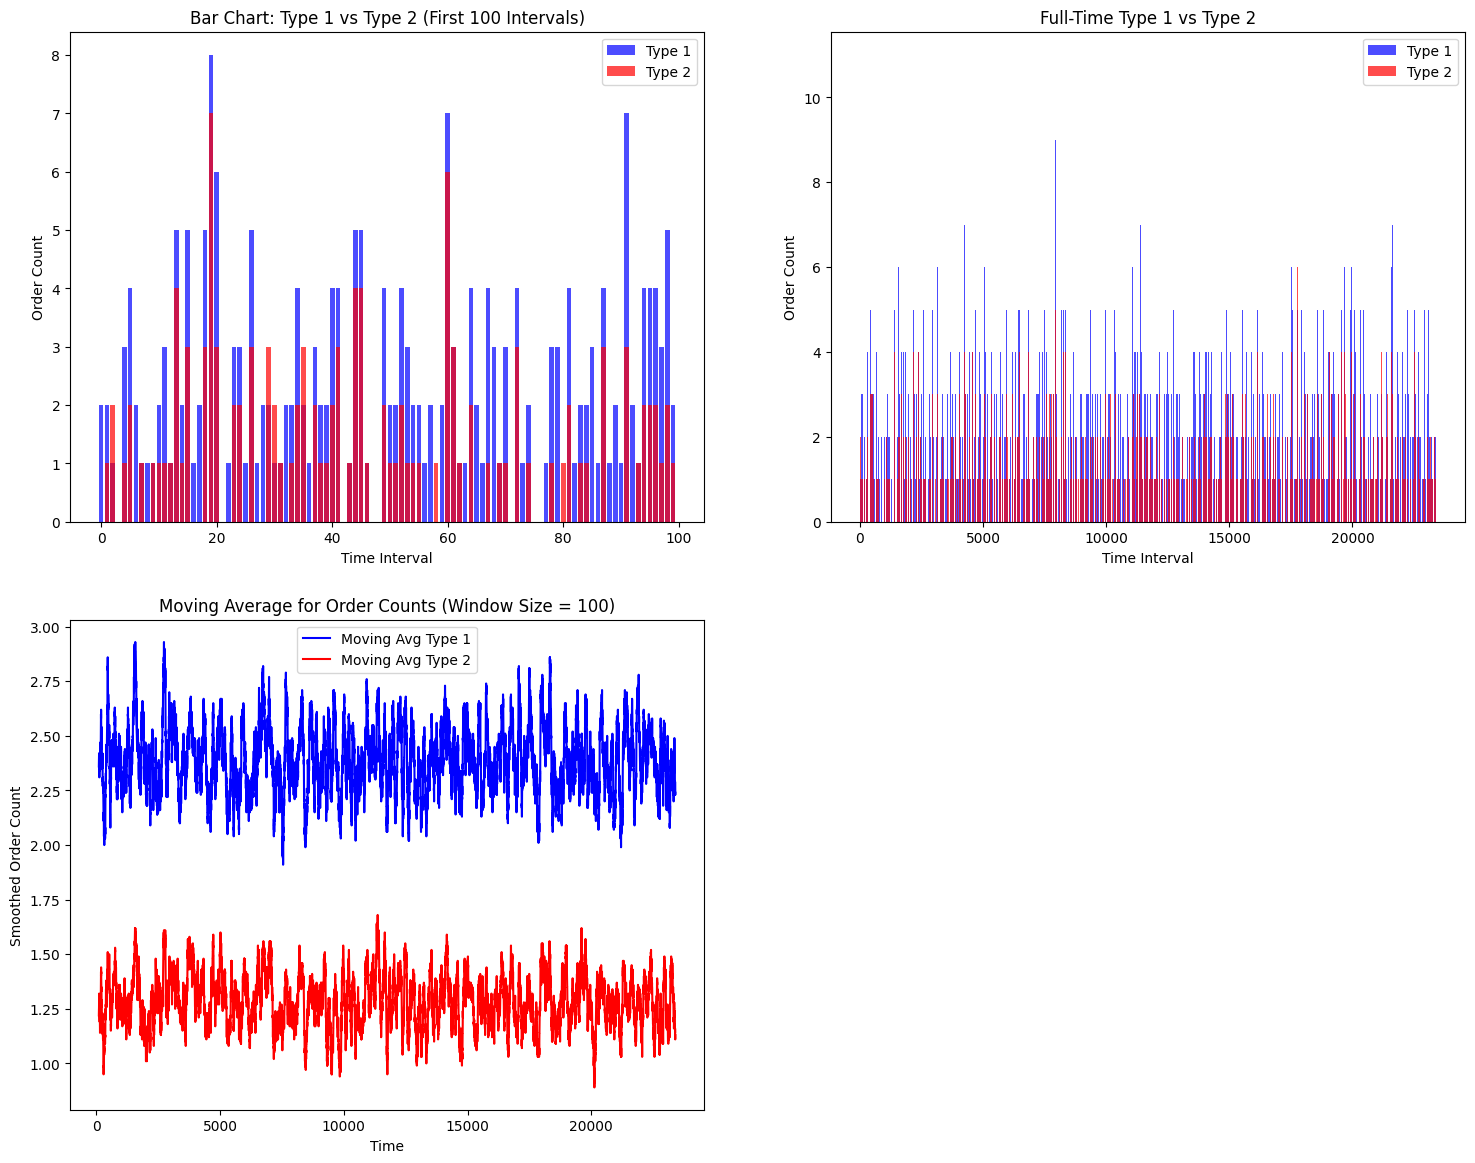

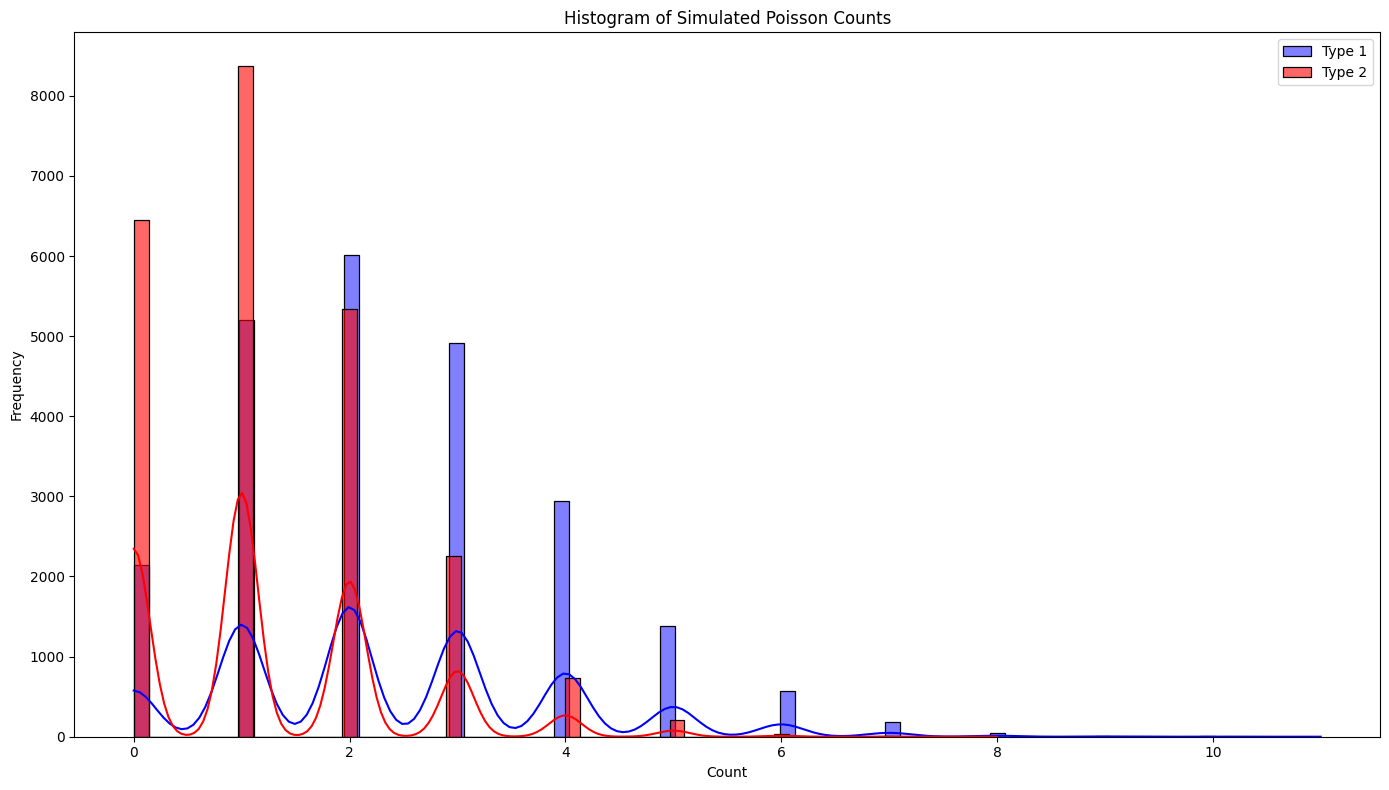

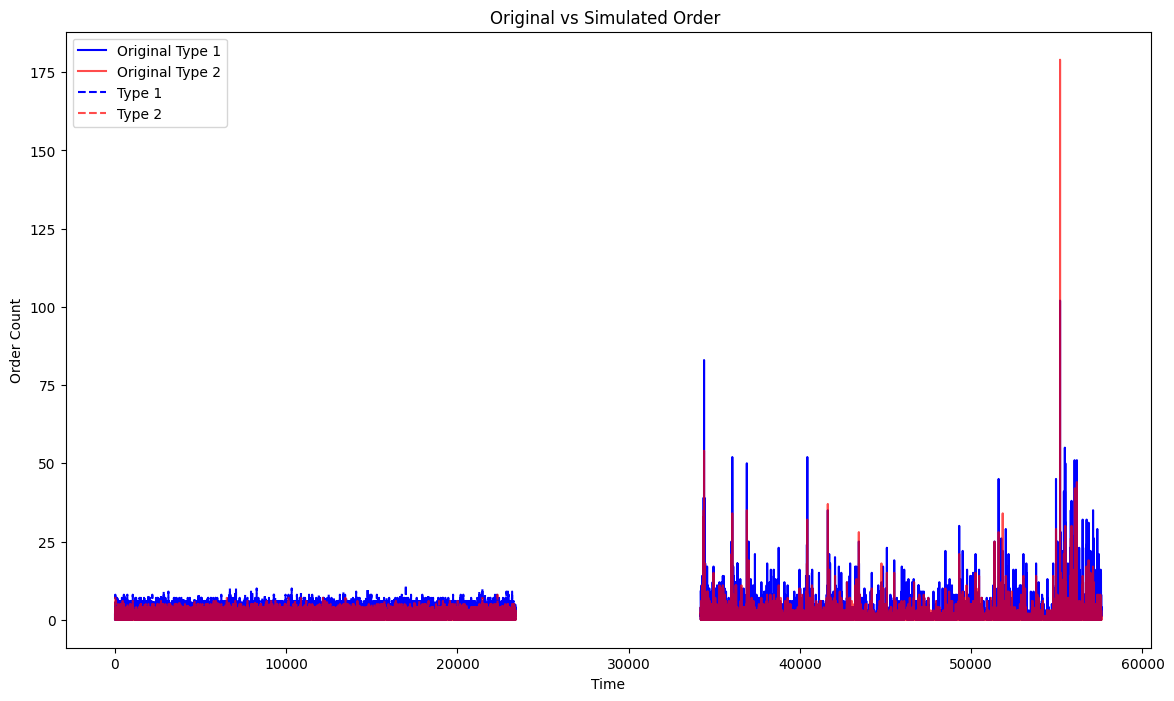

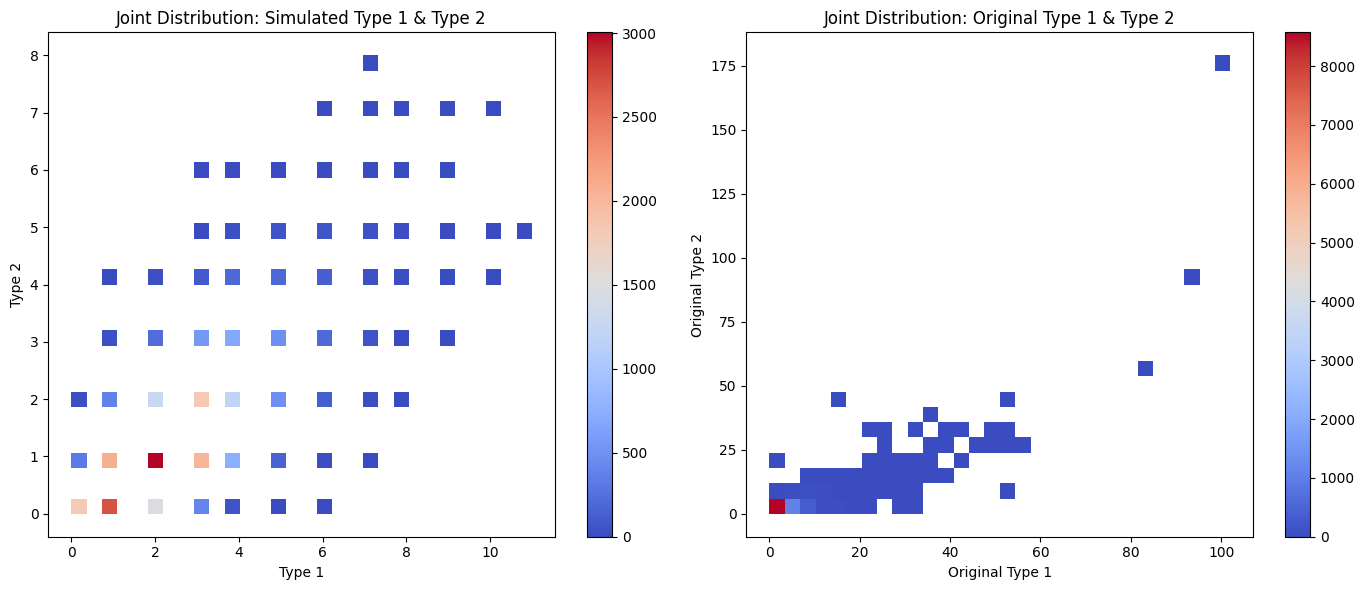

In [11]:


order_type1, order_type2 = 1, 3  # Can be any two from {1, 2, 3, 4, 5}
direction = 1  # Can be 1 (Bid), -1 (Ask), or None for both

# Aggregate order counts
order_counts, empirical_correlation, lambda_1, lambda_2 = aggregate_order_counts(df_message, order_type1, order_type2, direction)

# Simulate data
df_simulated, simulated_corr = simulate_orders(empirical_correlation, lambda_1, lambda_2)

# Display values
print(f"Empirical Correlation: {empirical_correlation}")
print(f"Simulated Correlation: {simulated_corr}")
print(f"Lambda1 (Type 1): {lambda_1}, Lambda2 (Type 2): {lambda_2}")

# Visualize results
visualize_data(df_simulated, order_counts, order_type1, order_type2, empirical_correlation, simulated_corr)


## Limit arrival and Partial cancellation orders

Empirical Correlation: 0.21788337483395553
Simulated Correlation: 0.08234294407256533
Lambda1 (Type 1): 4.031624623078621, Lambda2 (Type 2): 0.01853350003677282


C:\Users\krish\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


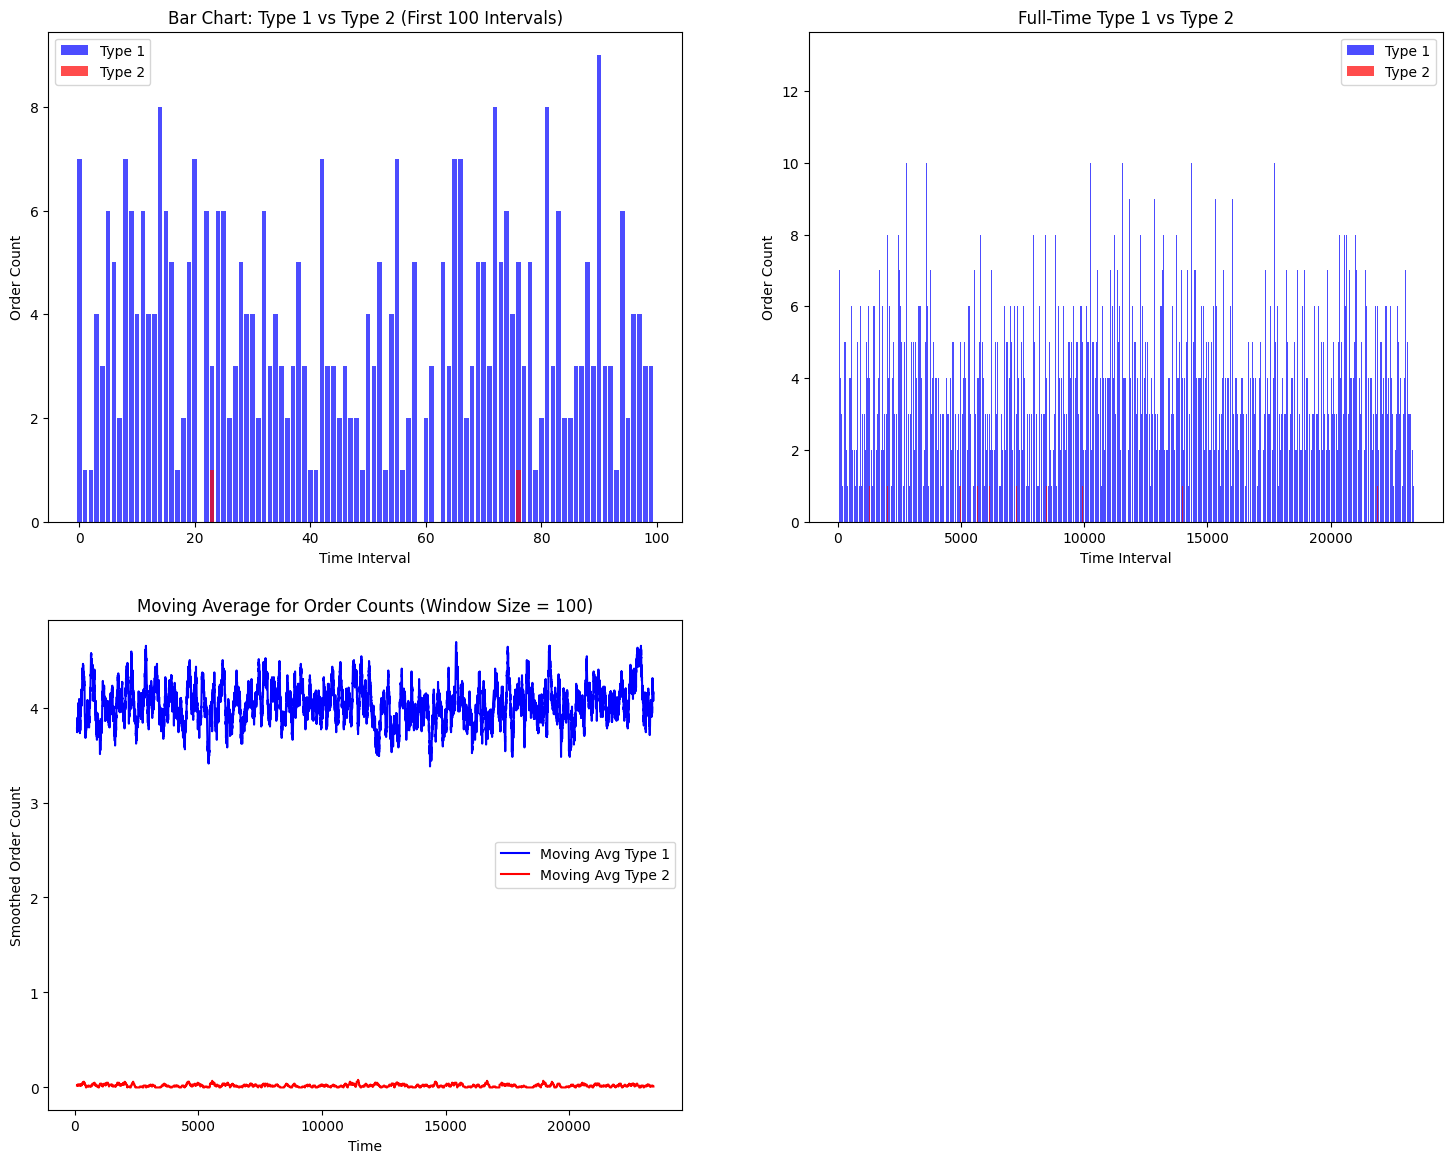

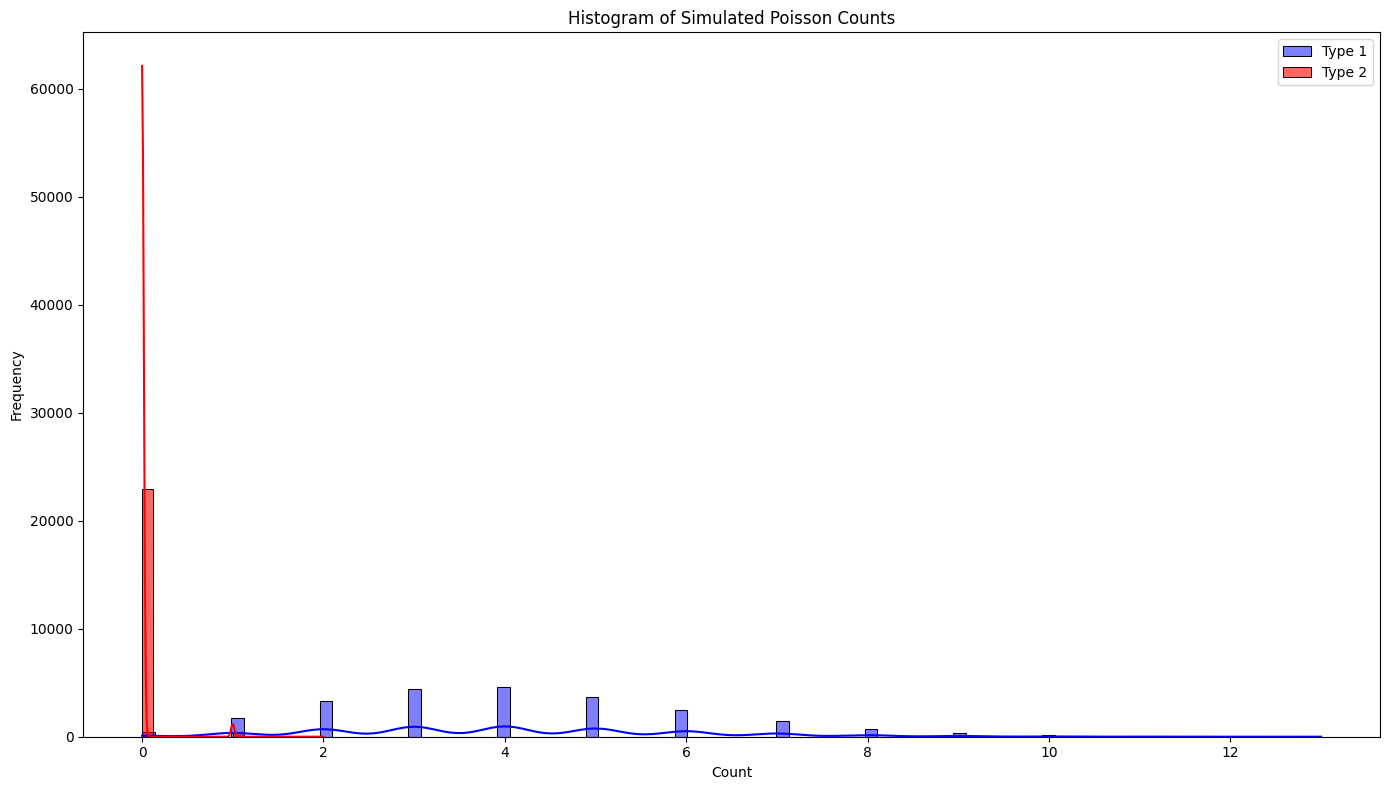

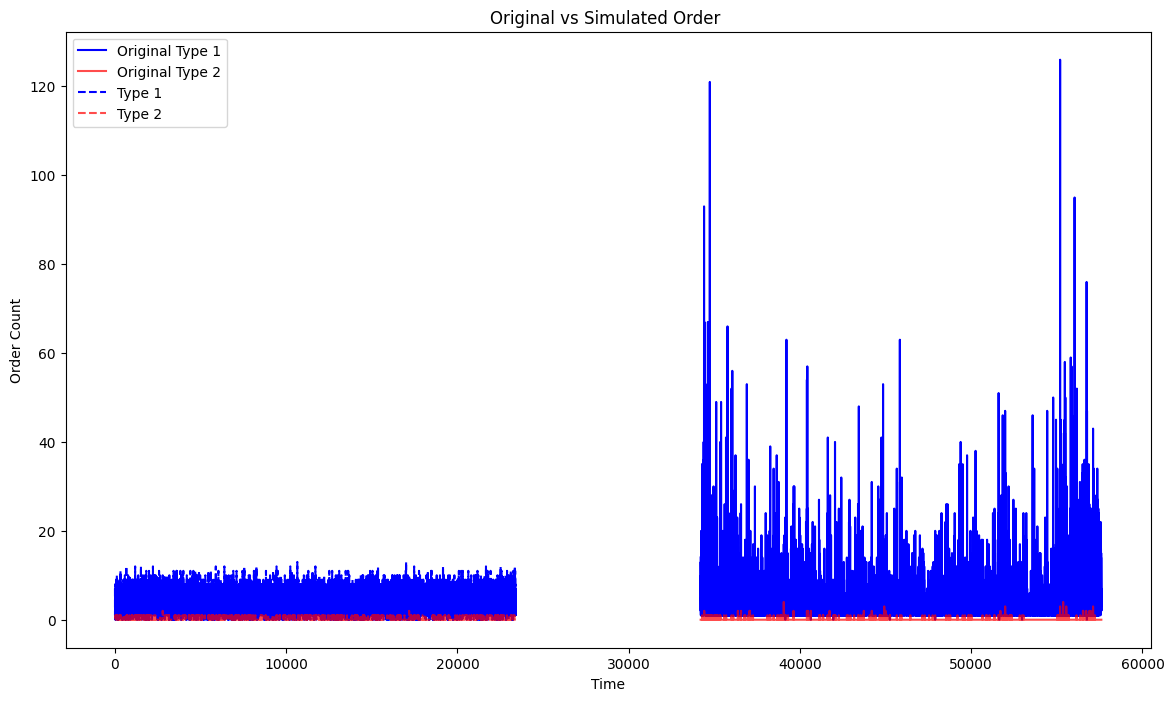

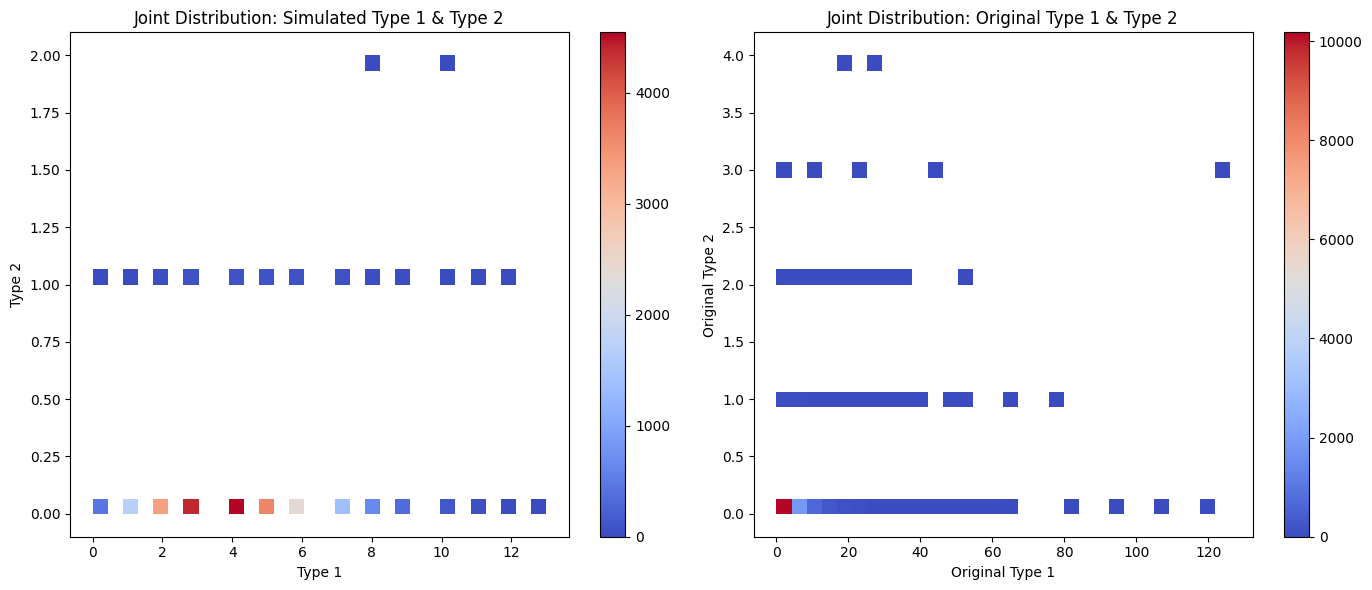

In [12]:


order_type1, order_type2 = 1, 2  # Can be any two from {1, 2, 3, 4, 5}
direction = None  # Can be 1 (Bid), -1 (Ask), or None for both

# Aggregate order counts
order_counts, empirical_correlation, lambda_1, lambda_2 = aggregate_order_counts(df_message, order_type1, order_type2, direction)

# Simulate data
df_simulated, simulated_corr = simulate_orders(empirical_correlation, lambda_1, lambda_2)

# Display values
print(f"Empirical Correlation: {empirical_correlation}")
print(f"Simulated Correlation: {simulated_corr}")
print(f"Lambda1 (Type 1): {lambda_1}, Lambda2 (Type 2): {lambda_2}")

# Visualize results
visualize_data(df_simulated, order_counts, order_type1, order_type2, empirical_correlation, simulated_corr)
